In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import warnings
import os
import shutil
import random
import numpy as np
from PIL import Image
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.callbacks import EarlyStopping

In [13]:


def load_sample_dataset(dataset_path, sample_size=500):
    """
    Simple function to create sample dataset and load it
    
    Args:
        dataset_path: Path to your unzipped dataset folder
        sample_size: Number of images per class
    """
    
    print(f"📂 Loading dataset from: {dataset_path}")
    
 
    sample_dir = "sample_dataset"
    os.makedirs(f"{sample_dir}/Parasitized", exist_ok=True)
    os.makedirs(f"{sample_dir}/Uninfected", exist_ok=True)
    
   
    parasitized_path = os.path.join(dataset_path, "Parasitized")
    uninfected_path = os.path.join(dataset_path, "Uninfected")
    
    
    if not os.path.exists(parasitized_path):
        print(f"❌ Path not found: {parasitized_path}")
        return None
    if not os.path.exists(uninfected_path):
        print(f"❌ Path not found: {uninfected_path}")
        return None
    
    
    parasitized_files = [f for f in os.listdir(parasitized_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    uninfected_files = [f for f in os.listdir(uninfected_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"📊 Found {len(parasitized_files)} parasitized images")
    print(f"📊 Found {len(uninfected_files)} uninfected images")
    
    
    parasitized_sample = random.sample(parasitized_files, min(sample_size, len(parasitized_files)))
    uninfected_sample = random.sample(uninfected_files, min(sample_size, len(uninfected_files)))
    
  
    print("📋 Creating sample dataset...")
    
    for file in parasitized_sample:
        src = os.path.join(parasitized_path, file)
        dst = os.path.join(sample_dir, "Parasitized", file)
        shutil.copy2(src, dst)
    
    for file in uninfected_sample:
        src = os.path.join(uninfected_path, file)
        dst = os.path.join(sample_dir, "Uninfected", file)
        shutil.copy2(src, dst)
    
    print(f"✅ Sample created: {len(parasitized_sample)} + {len(uninfected_sample)} images")
    print(f"🚀 Sample dataset ready at: {sample_dir}")
    
    return sample_dir


dataset_path = r"C:\Users\KevinNyiringango\SafeCell\archive (1)\cell_images"



sample_path = load_sample_dataset(dataset_path)

if sample_path:
    print(f"\n📁 Your sample dataset is ready at: {sample_path}")
else:
    print("\n❌ Failed to create sample dataset. Please check the path.")
    print(f"Expected folders: {dataset_path}/Parasitized and {dataset_path}/Uninfected")

📂 Loading dataset from: C:\Users\KevinNyiringango\SafeCell\archive (1)\cell_images
📊 Found 13779 parasitized images
📊 Found 13779 uninfected images
📋 Creating sample dataset...
✅ Sample created: 500 + 500 images
🚀 Sample dataset ready at: sample_dataset

📁 Your sample dataset is ready at: sample_dataset


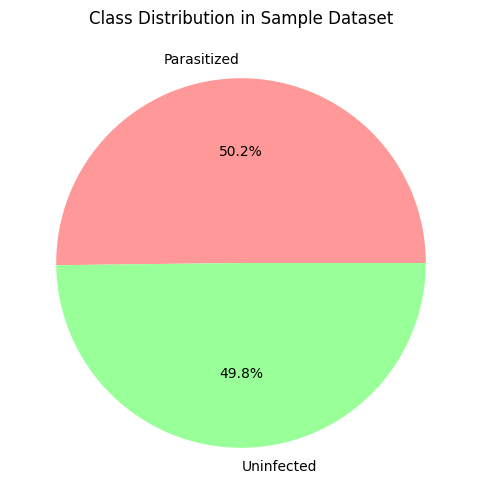

Found 4674 files belonging to 2 classes.
Using 3740 files for training.


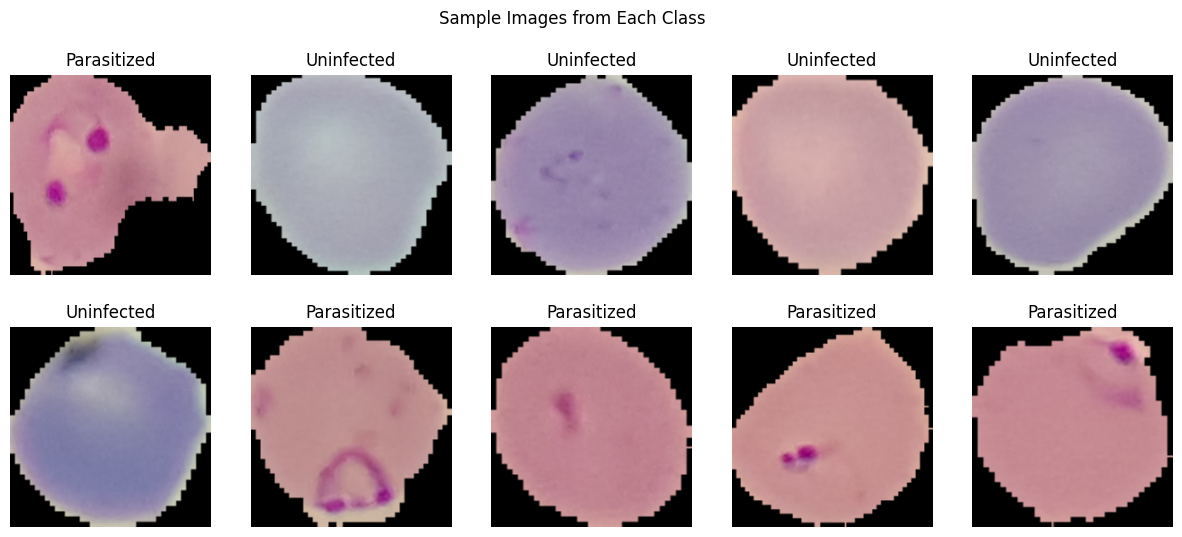

In [14]:

def plot_class_distribution_pie(sample_dir):
    class_folders = [d for d in os.listdir(sample_dir) if os.path.isdir(os.path.join(sample_dir, d))]
    counts = [len(os.listdir(os.path.join(sample_dir, c))) for c in class_folders]
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=class_folders, autopct='%1.1f%%', colors=['#ff9999','#99ff99'])
    plt.title("Class Distribution in Sample Dataset")
    plt.show()

def visualize_sample_images_with_predictions(dataset, model=None, class_names=None, samples_per_class=5):
    plt.figure(figsize=(15, 6))
    displayed = {name: 0 for name in class_names}
    total_displayed = 0
    max_total = samples_per_class * len(class_names)

    for images, labels in dataset.unbatch():
        label = labels.numpy()
        class_name = class_names[label]

        if displayed[class_name] < samples_per_class:
            plt.subplot(len(class_names), samples_per_class, total_displayed + 1)

            img = images.numpy().astype("uint8")
            plt.imshow(img)

            title = class_name
            if model:
                
                pred_probs = model.predict(tf.expand_dims(images, axis=0))
                pred_label = class_names[np.argmax(pred_probs)]
                title += f"\nTrue: {class_name}\nPred: {pred_label}"

            plt.title(title)
            plt.axis("off")
            displayed[class_name] += 1
            total_displayed += 1

        if total_displayed >= max_total:
            break

    plt.suptitle("Sample Images with True and Predicted Labels" if model else "Sample Images from Each Class")
    plt.show()



plot_class_distribution_pie(sample_path)


train_ds = keras.utils.image_dataset_from_directory(
    sample_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

class_names = ['Parasitized', 'Uninfected']
visualize_sample_images_with_predictions(train_ds, class_names=class_names)


In [ ]:



from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)


warnings.filterwarnings('ignore')


from keras import models, layers


def create_cnn_model(input_shape=(224, 224, 3), num_classes=2):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


model = create_cnn_model()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Found 2907 files belonging to 2 classes.
Using 2326 files for training.
Found 2907 files belonging to 2 classes.
Using 581 files for validation.
Classes: ['Parasitized', 'Uninfected']
Creating simple model for testing...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training simple model...
Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 27s 311ms/step - accuracy: 0.5040 - loss: 0.8233 - val_accuracy: 0.6024 - val_loss: 0.6770
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 289ms/step - accuracy: 0.6401 - loss: 0.6510 - val_accuracy: 0.6627 - val_loss: 0.6532
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - accuracy: 0.6992 - loss: 0.6229 - val_accuracy: 0.7676 - val_loss: 0.5276
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 293ms/step - accuracy: 0.8320 - loss: 0.4594 - val_accuracy: 0.9002 - val_loss: 0.4064
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - accuracy: 0.8880 - loss: 0.3639 - val_accuracy: 0.9071 - val_loss: 0.3559
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - accuracy: 0.8924 - loss: 0.3175 - val_accuracy: 0.9088 - val_loss: 0.3381
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 289ms/step - accuracy: 0.9294 - loss: 0.2332 - val_accuracy: 0.9346 - val_loss: 0.2743
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - accuracy: 0.9406 

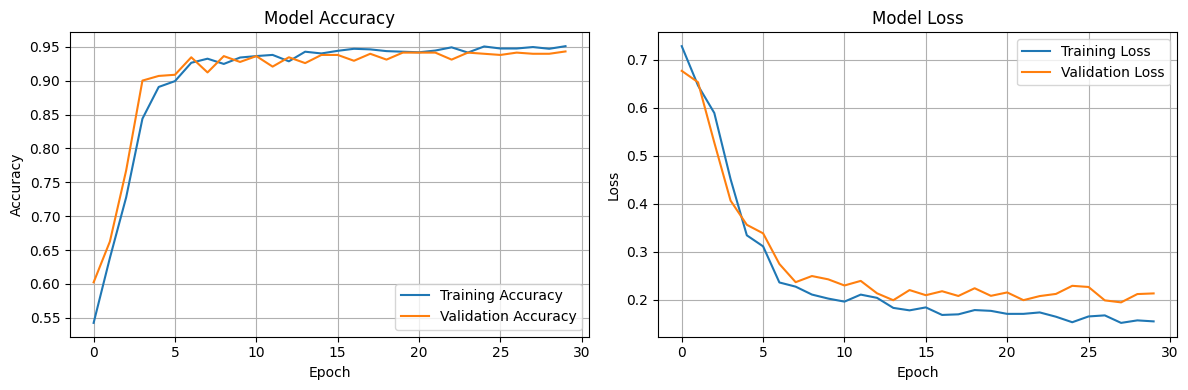


Training Set Distribution:

Class Distribution:
  Parasitized: 1174 samples (50.5%)
  Uninfected: 1152 samples (49.5%)

Validation Set Distribution:

Class Distribution:
  Parasitized: 285 samples (49.1%)
  Uninfected: 296 samples (50.9%)


In [ ]:

dataset_path = "sample_dataset"
image_size = (128, 128)  
batch_size = 32


train_dataset = keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode='int'
)

val_dataset = keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode='int'
)

class_names = train_dataset.class_names
print(f"Classes: {class_names}")


def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)


def create_simple_model(input_shape=(128, 128, 3), num_classes=2):
    model = models.Sequential([
        
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
      
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.2),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.2),
        
      
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.2),
        
      
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
  
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


print("Creating simple model for testing...")
simple_model = create_simple_model()
simple_model.summary()


early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,  
    restore_best_weights=True,
    verbose=1
)


print("Training simple model...")
history = simple_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,  
    callbacks=[early_stop],
    verbose=1
)


val_loss, val_acc = simple_model.evaluate(val_dataset, verbose=0)
print(f"\nSimple Model Results:")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Validation Loss: {val_loss:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


def check_class_distribution(dataset, class_names):
    class_counts = {name: 0 for name in class_names}
    total_samples = 0
    
    for images, labels in dataset:
        for label in labels:
            class_counts[class_names[label.numpy()]] += 1
            total_samples += 1
    
    print(f"\nClass Distribution:")
    for class_name, count in class_counts.items():
        percentage = (count / total_samples) * 100
        print(f"  {class_name}: {count} samples ({percentage:.1f}%)")
    
    return class_counts

print("\nTraining Set Distribution:")
train_dist = check_class_distribution(train_dataset, class_names)

print("\nValidation Set Distribution:")
val_dist = check_class_distribution(val_dataset, class_names)